### Part 5: Machine Learning

In [ ]:
#dummy model, linear regression 
#xgboosting, lightgbm, catboost
#ML from University of Washington 

In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import sklearn.linear_model as lm
import numpy as np

In [2]:
X = pd.read_csv('data/features.csv', parse_dates = [1], index_col = 0)
y = pd.read_csv('data/target.csv', parse_dates = [1], index_col = 0)

In [7]:
class BenchmarkModel:
    
    def predict(self, X_train, X_test):
        # pandas rolling function
        # next day predicitons, ARIMA vs linear reg/XGBoost
        # MAPE-mean absolute percentage error
        y_pred = np.mean(X_train['start_count_day_bf'].tail(7))
        self.y_pred = np.column_stack((X_test.index.tolist(), np.ones(7)*y_pred))
    
    def score(self, X_test, y_test):
        y_pred = self.y_pred[:, 1]
        self.residuals = y_test.values.reshape(-1) - y_pred
        return np.sqrt(np.mean(np.square(self.residuals)))
        
    def plot_results(self, y_train, y_test):
        predicted_line = np.vstack((y_train.reset_index().to_numpy(), self.y_pred))
        actual_line = np.vstack((y_train.reset_index().to_numpy(), y_test.reset_index().to_numpy()))
        
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches(15, 3)
        days = mdates.WeekdayLocator() 
        
        ax[0].plot(actual_line[:, 0], actual_line[:,1], color='b', linestyle='--', label='Actual')
        ax[0].plot(predicted_line[:, 0], predicted_line[:,1], color='r', label='Predicted')
        
        ax[0].xaxis.set_major_locator(days)
        ax[0].format_xdata = mdates.DateFormatter('%m-%d')
        ax[0].xaxis.set_tick_params(rotation=90)
        ax[0].legend()
        
        ax[1].plot(np.arange(len(y_test)), self.residuals, 'o', label='Residuals')
        ax[1].plot(np.arange(len(y_test)), np.zeros(len(y_test)), '--')
        ax[1].legend()

        plt.show()

8.57261896495857


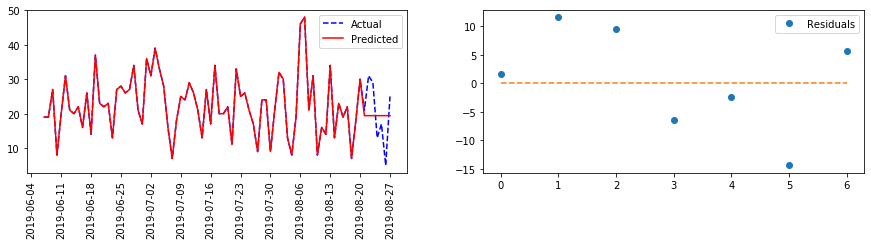

In [10]:
trainX = X[X['Date'] < '2019-08-15'].loc[1].reset_index(drop=True).set_index('Date')
trainY = y[y['Date'] < '2019-08-15'].loc[1].reset_index(drop=True).set_index('Date')[['count']]
testX = X[X['Date'] >= '2019-08-15'].loc[1].reset_index(drop=True).set_index('Date')
testY = y[y['Date'] >= '2019-08-15'].loc[1].reset_index(drop=True).set_index('Date')[['count']]
    
model = BenchmarkModel()
model.predict(trainX, testX)
print(model.score(testX, testY))
model.plot_results(trainY, testY)

In [181]:
for station in X.index.unique():
    
    scores = []
    print(station)
    
    trainX = X[X['Date'] < '2019-08-21'].loc[station].reset_index(drop=True).set_index('Date')
    trainY = y[y['Date'] < '2019-08-21'].loc[station].reset_index(drop=True).set_index('Date')[['count']]
    testX = X[X['Date'] >= '2019-08-21'].loc[station].reset_index(drop=True).set_index('Date')
    testY = y[y['Date'] >= '2019-08-21'].loc[station].reset_index(drop=True).set_index('Date')[['count']]
    
    model = BenchmarkModel()
    model.predict(trainX, testX)
    scores.append((station, model.score))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


ValueError: all the input array dimensions except for the concatenation axis must match exactly